In [1]:
import os
GPU_id = 0
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_id)

In [2]:
import pandas as pd
import cudf as gd
import numpy as np
from collections import OrderedDict,Counter
import re
from librmm_cffi import librmm
import nvstrings
import time
import draw
from termcolor import colored
from nvstring_workaround import get_unique_tokens,on_gpu,get_token_counts,is_in
import warnings

warnings.filterwarnings("ignore")

In [3]:
PATH = '/raid/data/ml/malware/input'

**The purpose of this notebook is to study the difference between train and test datasets in order to develop a robust validation scheme. This is important to the generalization capability of models to unseen dataset (test data on private leaderboard).** I'm also trying to use cudf and nvstring as much as possible.

### Table of contents
[1. Previous CV schemes](#prev)<br>
[2. Functions](#func)<br>
[3. Visualizations](#vis)<br>
[4. Conclusions](#conclusions)<br>

### 1. Previous CV schemes
<a id="prev"></a>
Previously, I used the naive __[K-Fold cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)__ with random shuffling and observed some discrepencies between cross validation AUC (CV) and leaderboard AUC (LB) as follows: 

In [4]:
scores = pd.DataFrame({'models':['lgb1','lgb2','ffm','nn'],'CV':[0.730,0.732,0.727,0.729],'LB':[0.675,0.672,0.680,0.678]})
scores['description'] = ['lightGBM','lightGBM with mean target features','Field aware factorization machine', 'Neural network']
scores = scores.set_index('models')
scores

,CV,LB,description
models,,,
lgb1,0.730,0.675,lightGBM
lgb2,0.732,0.672,lightGBM with mean target features
ffm,0.727,0.680,Field aware factorization machine
nn,0.729,0.678,Neural network


Two points to be noted from the table above:
1. **CV AUC is higher than LB** which means there is some overfitting.
2. **Improvement of CV doesn't lead to improvement of LB** which means the split between train and test dataset is *not* the same as the KFOLD random split.

Actually, <font color=red>the dataset provided here has been roughly __[split by time](https://www.kaggle.com/c/microsoft-malware-prediction/data)__.</font> And random split for time series is __[not a good idea](https://www.datapred.com/blog/advanced-cross-validation-tips)__. 

I believe a time-based split will 1) reduce the gap between CV and LB and more importantly 2) align the improvement of CV to LB so that we can evaluate ETL, feature/model selection locally without submitting to kaggle.

What's annoying is the dataset **doesn't include an explicit timestamp column**, so we have to infer the timing information from other columns. My intuitive assumption is that the version number of the defender software contains timing information: higher version number means more recent observations. Hence, in this notebook, I'll study these 4 columns:
1. *ProductName* - Defender state information e.g. win8defender
2. *EngineVersion* - Defender state information e.g. 1.1.12603.0
3. *AppVersion* - Defender state information e.g. 4.9.10586.0
4. *AvSigVersion* - Defender state information e.g. 1.217.1014.0

<a id="func"></a>
### 2. Functions

In [5]:
def rmse(a,b):
    """compute root mean square error of two numpy arrays
    """
    return np.mean((a-b)**2)**0.5

In [6]:
def get_topk_token_count(nvs,k=5):
    """get top-k token counts of a nvstring object
    
    Parameters
    ----------
    nvs : a nvstring object, 
    k : integer, for top-k
        
    Returns
    ----------
    nvs_count : a dictionary (collections.Counter) token (str) => count (int)
        including all tokens of that nvstring
    nvs_count_topk : a dictionary (collections.Counter) token (str) => count (int)
        including top-k frequent tokens of that nvstring
    """
    nvs_count = get_token_counts(nvs)
    nvs_count_topk = dict(nvs_count.most_common(k)) 
    sum_top = sum([j for i,j in nvs_count_topk.items()])
    ratio = '%.4f'%(sum_top/nvs.size())
    ratio = colored(ratio,'red')
    print('# of unique values: %d, top%d %s, top%d percentage:'%(len(nvs_count),k,str(nvs_count_topk),k),ratio)    
    return nvs_count,nvs_count_topk

In [7]:
def overlap_piechart(train_count,test_count,title):
    """draw a pie chart of overlapped ratio between two datasets
    Parameters
    ----------
    train_count : a dictionary (collections.Counter) token (str) => count (int)
        for train data
    test_count : a dictionary (collections.Counter) token (str) => count (int)
        for test data
        
    """
    train_in_test = is_in(train_count,test_count)
    test_in_train = is_in(test_count,train_count)
    t1 = colored('%.3f'%train_in_test,'red')
    t2 = colored('%.3f'%test_in_train,'red')
    print('train_in_test ratio',t1,' test_in_train ratio',t2)
    data = []
    data.append({'in test':train_in_test,'not in test':1-train_in_test})
    data.append({'in train':test_in_train,'not in train':1-test_in_train})
    tags = ['train data','test data']
    draw.pie_chart(data,tags,title=title,figsize=(16,4))

<a id="vis"></a>
### 3. Visualizations

In [8]:
%%time
# peak gpu memory usage is 17GB!
cols = ['ProductName', 'EngineVersion', 'AppVersion', 'AvSigVersion']
train = gd.read_csv('%s/train.csv'%PATH,usecols=cols)
test = gd.read_csv('%s/test.csv'%PATH,usecols=cols)

CPU times: user 5.09 s, sys: 1.22 s, total: 6.31 s
Wall time: 6.3 s


**ProductName: name of the defender software**

In [9]:
%%time
col = 'ProductName'
train_count = get_token_counts(train[col].data)
print('train',train_count)
test_count = get_token_counts(test[col].data)
print('test',test_count)

train Counter({'win8defender': 8826520, 'mse': 94873, 'mseprerelease': 53, 'scep': 22, 'windowsintune': 8, 'fep': 7})
test Counter({'win8defender': 7797245, 'mse': 55946, 'mseprerelease': 34, 'scep': 16, 'fep': 7, 'windowsintune': 5})
CPU times: user 1.96 s, sys: 232 ms, total: 2.19 s
Wall time: 2.24 s


**The following pie charts show that**:
1. there are 6 difference product names in both train and test
2. most samples are from product *win8defender*
3. the distribution is similar in train and test

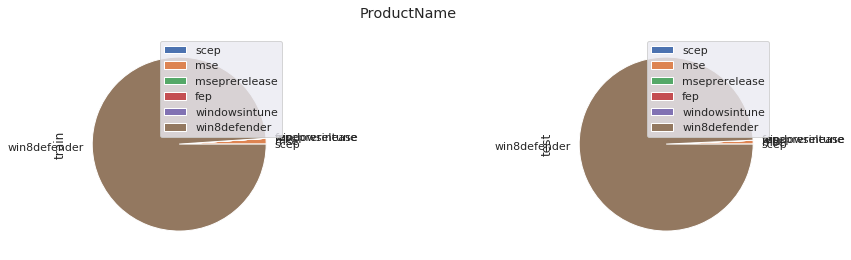

In [10]:
draw.pie_chart([train_count,test_count],['train','test'],title=col,figsize=(16,4))

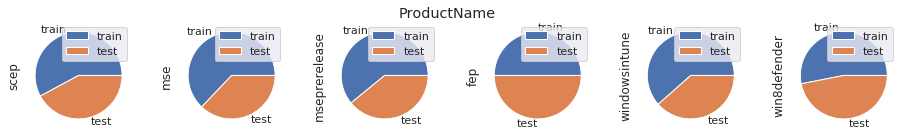

In [11]:
draw.pie_chart([train_count,test_count],['train','test'],title=col,transpose=True,figsize=(16,2))

train_in_test ratio 1.000  test_in_train ratio 1.000


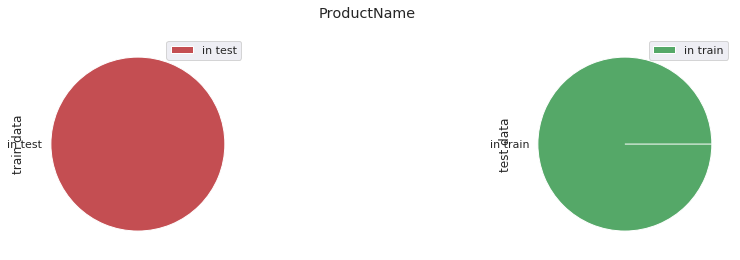

In [12]:
overlap_piechart(train_count,test_count,col)

**AvSigVersion**

In [13]:
%%time
col = 'AvSigVersion'
k = 5
print("==============Train==============")
train_count,train_count_topk = get_topk_token_count(train[col].data,k)
print("==============Test==============")
test_count,test_count_topk = get_topk_token_count(test[col].data,k)

==============Train==============
# of unique values: 8268, top5 {'1.275.1244.0': 78902, '1.251.42.0': 76837, '1.275.1209.0': 66393, '1.273.810.0': 65895, '1.273.1749.0': 65381}, top5 percentage: 0.0396
==============Test==============
# of unique values: 9176, top5 {'1.277.515.0': 80393, '1.279.102.0': 73108, '1.277.1044.0': 54981, '1.277.1102.0': 52147, '1.237.0.0': 47158}, top5 percentage: 0.0392
CPU times: user 580 ms, sys: 224 ms, total: 804 ms
Wall time: 805 ms


**Observations:**
1. there are 8k~9k difference AvSigVersions in train and test
2. the top 5 AvSigVersions in terms of counts account for 3% of the total population. 

We look at the top-5 AvSigVersions with the pie charts below

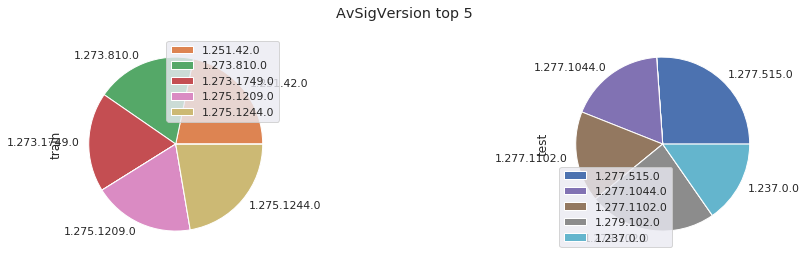

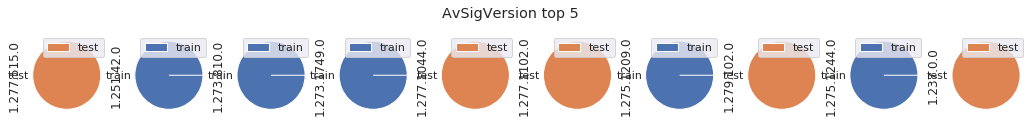

In [14]:
draw.pie_chart([train_count_topk,test_count_topk],['train','test'],title=col+' top 5',figsize=(16,4))
draw.pie_chart([train_count_topk,test_count_topk],['train','test'],title=col+' top 5',figsize=(18,2),transpose=True)

**Observations**
1. The top-5 AvSigVersion of train and test are completely different and they have no overlap. 
2. For example, `1.277.1102.0` can only be found in test data but not in train data. Similarly, `1.251.42.0` can only be found in train data but not in test data.
3. the top 5 of train are 1.251.x ~ 1.275.x and 4 of the top 5 of test is above 1.277.x. This may indicate that higher version number is from more recent observations. 
4. we could use AvSigVersion as a timestamp to split data

train_in_test ratio 0.966  test_in_train ratio 0.154


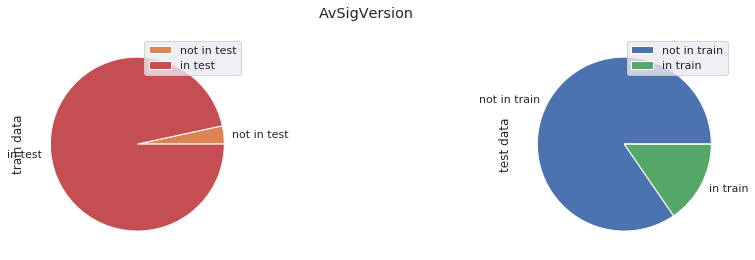

In [15]:
overlap_piechart(train_count,test_count,col)

**We also look at overall token counts instead of just top-5 tokens**
1. for test data, there are only 15.3% of samples whose AvSigVersion present in train data. This indicates that most of test data are with new AvSigVersions.
2. for train data, there are 97.5% samples whose AvSigVersion present in test data. This indicates the 15.3% test data (the red slice of the left pie chart) actually contain most of the AvSigVersions of train. 

**The similar analysis is also done to EngineVersion and AppVersion**

In [16]:
%%time
col = 'EngineVersion'
k = 5
print("==============Train==============")
train_count,train_count_topk = get_topk_token_count(train[col].data,k)
print("==============Test==============")
test_count,test_count_topk = get_topk_token_count(test[col].data,k)

==============Train==============
# of unique values: 68, top5 {'1.1.15000.2': 265218, '1.1.15200.1': 212408, '1.1.14600.4': 160585, '1.1.14800.3': 136476, '1.1.15300.6': 120295}, top5 percentage: 0.1003
==============Test==============
# of unique values: 69, top5 {'1.1.15300.6': 3101305, '1.1.15400.4': 2106236, '1.1.15200.1': 366085, '1.1.15100.1': 158036, '1.1.14600.4': 138514}, top5 percentage: 0.7475
CPU times: user 708 ms, sys: 232 ms, total: 940 ms
Wall time: 941 ms


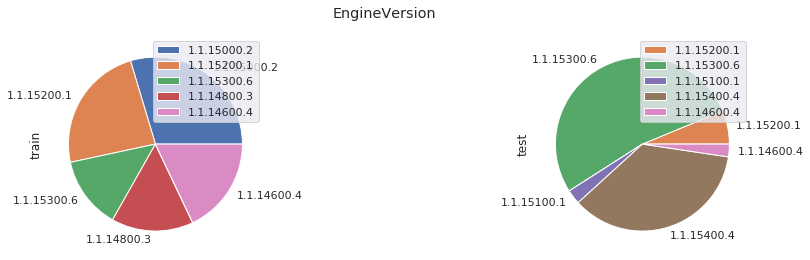

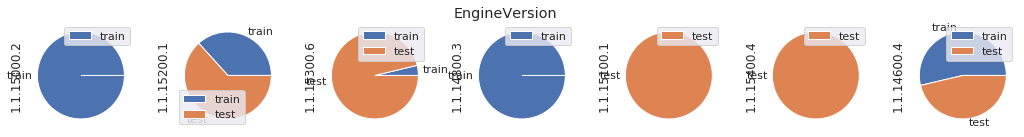

In [17]:
draw.pie_chart([train_count_topk,test_count_topk],['train','test'],title=col,figsize=(16,4))
draw.pie_chart([train_count_topk,test_count_topk],['train','test'],title=col,figsize=(18,2),transpose=True)

train_in_test ratio 1.000  test_in_train ratio 0.653


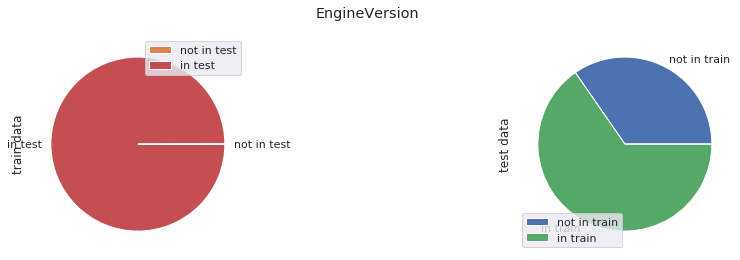

In [18]:
overlap_piechart(train_count,test_count,col)

In [19]:
%%time
col = 'AppVersion'
k = 5
print("==============Train==============")
train_count,train_count_topk = get_topk_token_count(train[col].data,k)
print("==============Test==============")
test_count,test_count_topk = get_topk_token_count(test[col].data,k)

==============Train==============
# of unique values: 104, top5 {'4.18.1806.18062': 850929, '4.12.16299.15': 359871, '4.10.209.0': 272455, '4.13.17134.1': 257270, '4.16.17656.18052': 235032}, top5 percentage: 0.2214
==============Test==============
# of unique values: 118, top5 {'4.18.1809.2': 2738721, '4.18.1810.5': 2129928, '4.12.16299.15': 267102, '4.13.17134.1': 231117, '4.8.10240.17443': 193085}, top5 percentage: 0.7080
CPU times: user 572 ms, sys: 208 ms, total: 780 ms
Wall time: 781 ms


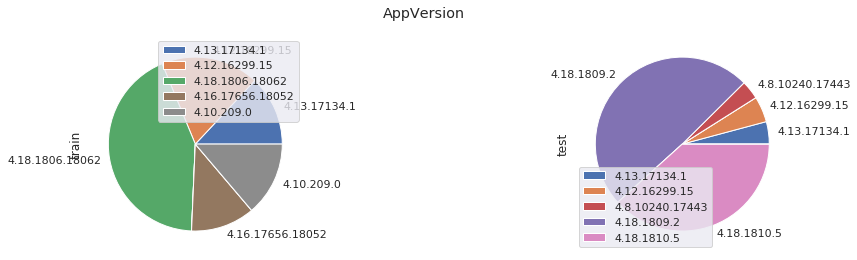

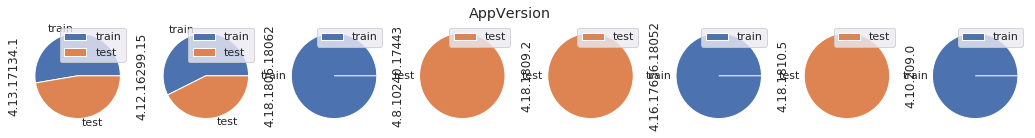

In [20]:
draw.pie_chart([train_count_topk,test_count_topk],['train','test'],title=col,figsize=(16,4))
draw.pie_chart([train_count_topk,test_count_topk],['train','test'],title=col,figsize=(18,2),transpose=True)

train_in_test ratio 0.999  test_in_train ratio 0.668


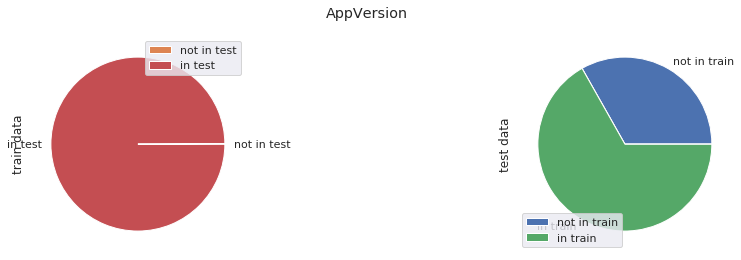

In [21]:
overlap_piechart(train_count,test_count,col)

<a id="conclusions"></a>
### 4. Conclusions

1. I'm going to try to use **AvSigVersion** to split train data into two parts: local train data and local validation data, which mimics the difference between train data and test data.
2. Specifically, most of the local validation data will be with unseen AvSigVersion numbers w.r.t local train data. but it also contains a small subset that with all AvSigVersions from train data.
3. I'm going to run exist models with this split and record their CV AUC score. If the assumption is correct, we should see smaller gap between CV and LB and more consistent patterns between CV and LB.